# Booleabayes Example 
Function call types:
* `load` = loading data
* `proc` = processing
* `rw` = random walk
* `plot` = plotting
* `tl` = tools (including rule fitting and finding attractors)
* `utils` = utilities

In [1]:
import sys
import os
import time
import random
import os.path as op
from datetime import timedelta
import pandas as pd

import booleabayes as bb


(ipykernel_launcher.py:86933): Gtk-WARNING **: 14:39:37.666: Locale not supported by C library.
	Using the fallback 'C' locale.


Booleabayes can be run on bulk RNA-seq data or single-cell RNA-seq data. If you are interested in using metadata such as cluster information, include this data below. Booleabayes takes in a network file with two columns: the first column should be the parent nodes and the second column should be the child nodes of each edge in the network. 

In [2]:
# Input data locations
DATA_DIR = './test_data'
network_path = 'tf-lit-network.csv' #literature-derived network
data_path = 'data.csv' # sample data is a subset of data from PMID: 31068696
cellID_table = 'cellID-lookuptable_x1.csv' #metadata from PMID: 31068696

# Output directories
OUTPUT_DIR = './output'
VAL_DIR = './output/validation'
ATTRACTOR_DIR = "./output/attractors"
PERTURB_DIR = "./output/perturbations"


## Load Network

BooleaBayes starts with a network of nodes connected by edges. This network can be filtered and pruned with BooleaBayes using the gene expression data in later steps, and the exact edge weights will be predicted (positive/activating or negative) and used in simulations. 

In [3]:
# Load the tf network and generate a graph using graph-tool
graph, vertex_dict = bb.load.load_network(f'{DATA_DIR}/{network_path}', remove_sinks=False, remove_selfloops=True,
                                              remove_sources=False)

# Maps: vertex -> name (basically the inverse of vertex_dict)
v_names, nodes = bb.utils.get_nodes(vertex_dict, graph)

# Print out information about the network, with optional simple plot of network
bb.utils.print_graph_info(graph, vertex_dict, nodes, dir_prefix = OUTPUT_DIR,plot = True, add_edge_weights=False)

# Note that for our particular network, JUN is a source, meaning it has no parents. 
# A pseudo-self-loop will be added (if it doesn't exist already) and JUN expression will be predicted from itself.

Graph properties
<Graph object, directed, with 16 vertices and 63 edges, 3 internal vertex properties, at 0x1d7cb5ee0>
Number of nodes: 16
Nodes:  ['ARX', 'FOXA2', 'GCG', 'INS', 'ISL1', 'JUN', 'MAFA', 'MAFB', 'MYC', 'NEUROD1', 'NEUROG3', 'NKX2-2', 'NKX6-1', 'PAX4', 'PAX6', 'PDX1']
Sources:  1 ['JUN']
Sinks:  2 ['INS', 'GCG']
Network is a single connected component:  True
Directed acyclic graph:  False


In [17]:
graph

<Graph object, directed, with 16 vertices and 63 edges, 3 internal vertex properties, at 0x109bdbee0>

## Load Data and Clusters & Split into Training and Testing Sets
* BooleaBayes takes bulk or single cell RNA-seq data in the format of samples (columns) by genes (rows) [Note option to transpose from csv]. It can take two timepoints or pseudotimepoints if they exist (i.e. from a trajectory inference method) as data_t0 and data_t1. Note that if the timepoints are significantly far apart (hours), the predictions may not work as well.
* The `utils.get_clusters()` function to handle creating the cluster dataframe
    - The function checks for a `cellID` table and column headers to create the dataframe
    - If no `cellID` table is passed the dataframe is created using the data index with one `class` column filled with zero's
* Example function call with data that is already split into train/test:

```python
clusters = ut.get_clusters(data_train, data_test, is_data_split=True, 
                           cellID_table="cellID_table.csv",
                           cluster_header_list=cluster_header_list)
```
* Example function call with no `cellID` table:

```python
clusters = ut.get_clusters(data_t0)
```
* View output format in `./test_data/output`:
    - train_t0.csv
    - train_t1.csv (if t1 is given)
    - test_t0.csv
    - test_t1.csv (if t1 is given)
    - test_train_indeces_cline.p

In [22]:
# Assign headers to cluster csv, with one called "class"
cluster_header_list = ['CellStage','class','CellProtocol']
node_normalization = 0.3 #look at documentation to understand the options for normalizing the data. 
transpose = True

data = bb.load.load_data(f'{DATA_DIR}/{data_path}', nodes, norm=node_normalization,
                        delimiter=',', log1p=False, transpose=transpose,
                        sample_order=False, fillna=0)
# Only need to pass 'data' since this data is not split into train/test
clusters = bb.utils.get_clusters(data, cellID_table=f"{DATA_DIR}/{cellID_table}",
                               cluster_header_list=cluster_header_list)

os.mkdir(f"{DATA_DIR}/data_split")
data_train, data_test, _, _, clusters_train, clusters_test =  bb.utils.split_train_test(data, data_t1 = None, clusters = clusters,
                                                                                                        save_dir = f"{OUTPUT_DIR}/data_split")

## Binarize data
* The `save` parameter in `proc.binararize_data()` lets users determine if they want the binarized data written to a location sepcified by `save_dir` and `fname`
* View output format in `./test_data/output`:
    - binarized_data_t0.csv
    - binarized_data_t1.csv
    - binarized_data_test_t0.csv
    - binarized_data_test_t1.csv

In [23]:
binarized_data = bb.proc.binarize_data(data_train, phenotype_labels=clusters, save=True,
                                       save_dir=OUTPUT_DIR, fname='binarized_data_train')

binarized_data_test = bb.proc.binarize_data(data_test, phenotype_labels=clusters, save=True,
                                            save_dir=OUTPUT_DIR, fname='binarized_data_test')

## Fit rules with training dataset
**Option 1:** Calculate rules using `tl.get_rules_scvelo()` or `tl.get_rules()`. See documentation for get_rules_scvelo(), which takes in two [pseudo]timepoints.
* User has the option to plot and save the rules using the following function arguments:
    - `plot` - determines if the plots should be created. Reference Wooten, Groves et al. 2019 for a walk-through of rule plots.
    - `show_plot` - determines if the plots should be shown in std. out
    - `save_plot` - determines if the plots should be saved
    - `save_dir` - file path to save the plots
* View output format in `./test_data/output`:
    - rule_plots/*
    - rules.txt
    - strengths.csv
    - signed_strengths.csv

In [25]:
# Don't remove any parents
node_threshold = 0  

# Note: this step may take a while. Nodes with more parents will take longer than others.
# For the test data it should take around 45 minutes. Note that we are working on a parallelized method for rule fitting.
# Also note that this is much quicker for bulk RNA-seq because the time depends on the number of samples.
rules, regulators_dict,strengths, signed_strengths = bb.tl.get_rules(data = data_train,
                                                                             vertex_dict=vertex_dict,
                                                                             plot=True, show_plot=False, save_plot=True,
                                                                             save_dir=f'{OUTPUT_DIR}/rules/rule_plots',
                                                                             threshold=node_threshold)

# Save rules to text file. This file can  then be read in 
bb.tl.save_rules(rules, regulators_dict, fname=f'{OUTPUT_DIR}/rules.txt')

strengths.to_csv(f'{OUTPUT_DIR}/rules/strengths.csv')
signed_strengths.to_csv(f'{OUTPUT_DIR}/rules/signed_strengths.csv')


Fitting  0 / 16 rules
JUN
0
...checking if JUN is irrelevant
Fitting  1 / 16 rules
MYC
0
...checking if PDX1 is irrelevant
Fitting  2 / 16 rules
INS
0
100
200
300
400
500
...checking if PDX1 is irrelevant
...checking if MAFA is irrelevant
...checking if PAX6 is irrelevant
...checking if NEUROD1 is irrelevant
...checking if NKX2-2 is irrelevant
...checking if MAFB is irrelevant
...checking if JUN is irrelevant
...checking if ISL1 is irrelevant
...checking if MYC is irrelevant
Fitting  3 / 16 rules
MAFA
0
100
200
...checking if PDX1 is irrelevant
...checking if NKX6-1 is irrelevant
...checking if NEUROD1 is irrelevant
...checking if NKX2-2 is irrelevant
...checking if FOXA2 is irrelevant
...checking if MAFB is irrelevant
...checking if JUN is irrelevant
...checking if ISL1 is irrelevant
Fitting  4 / 16 rules
NEUROG3
0
...checking if NKX6-1 is irrelevant
Fitting  5 / 16 rules
ARX
0
100
...checking if PAX4 is irrelevant
...checking if PDX1 is irrelevant
...checking if NKX6-1 is irrelevant


AttributeError: module 'booleabayes.utils' has no attribute 'draw_grn'

In [33]:
#Draw the network with the edge weights from the fitted rules
gene2color = {'ARX':[0.98, 0.553, 0,1],'FOXA2':[0.078, 0.42, 0.043,1],'GCG':[0.98, 0.553, 0,1],'INS':[0.212, 0.365, 0.78,1],'ISL1':[0.078, 0.42, 0.043,1],'JUN':[0.98, 0.553, 0,1],
              'MAFA':[0.212, 0.365, 0.78,1],'MAFB':[0.98, 0.553, 0,1],'MYC':[0.98, 0.553, 0,1],'NEUROD1':[0.078, 0.42, 0.043,1], 'NEUROG3':[0.29, 0.29, 0.29,1],
              'NKX2-2':[0.078, 0.42, 0.043,1],'NKX6-1':[0.212, 0.365, 0.78,1],'PAX4':[0.212, 0.365, 0.78,1],'PAX6':[0.078, 0.42, 0.043,1],'PDX1':[0.212, 0.365, 0.78,1]}

G, edge_weight_df, edge_binary_df = bb.plot.draw_grn(graph,vertex_dict,rules, regulators_dict,f"{OUTPUT_DIR}/network.pdf", save_edge_weights=True,
             edge_weights_fname=f"{OUTPUT_DIR}/rules/edge_weights.csv", gene2color=gene2color)

**Option 2:** Load existing rules (such as ones previously generated with Option 1) from file using `load.load_rules()`

In [15]:
rules, regulators_dict = bb.load.load_rules(fname=f'{OUTPUT_DIR}/rules.txt')


## Perform Cross Validation and Plot Accuracy Metrics

User can call the `tl.fit_validation()` to do cross validation with the test data set.
* User can specify whether to show and/or save the plots (this example saves the plots but does not show them here)
* View output format in `./test_data/validation`:
    - tprs_fprs.csv
    - accuracy_plots (csv and pdf)

In [36]:

os.mkdir(VAL_DIR)
validation, tprs_all, fprs_all, area_all = bb.tl.fit_validation(data_test, data_test_t1 = None, nodes = nodes,
                                                                regulators_dict=regulators_dict, rules = rules,
                                                                save=True, save_dir=VAL_DIR,
                                                                plot = True, show_plots=False, save_df=True)

**AUC Plots**
* View output format in `./output/validation`:
    - aucs.csv
    - aucs_plot.pdf
    - ROC_AUC_average.pdf

In [37]:
# Saves auc values for each gene (node) in the passed directory as 'aucs.csv'
bb.tl.save_auc_by_gene(area_all, nodes, VAL_DIR)

AUC means:  0
ARX        0.994043
FOXA2      0.682869
GCG        0.992152
INS        0.995997
ISL1       0.881050
JUN        0.999966
MAFA       0.918799
MAFB       0.993769
MYC        0.484198
NEUROD1    0.991058
NEUROG3    0.806586
NKX2-2     0.996675
NKX6-1     0.866948
PAX4       0.948326
PAX6       0.979637
PDX1       0.887367
dtype: float64


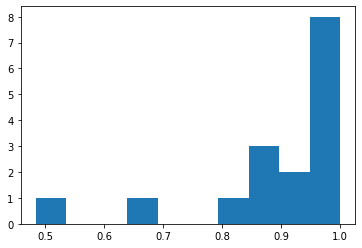

In [39]:
# Plot aucs
n = len(nodes)
aucs = pd.read_csv(f'{VAL_DIR}/aucs.csv', header=None, index_col=0)
print("AUC means: ",aucs.mean(axis = 1))

bb.plot.plot_aucs(VAL_DIR, save=True, show_plot=True)

In [40]:
# Function to calculate roc and tpr, fpr, area from saved validation files
tpr_all, fpr_all, area_all = bb.tl.roc_from_file(f'{VAL_DIR}/accuracy_plots', nodes, save=True, save_dir=VAL_DIR)

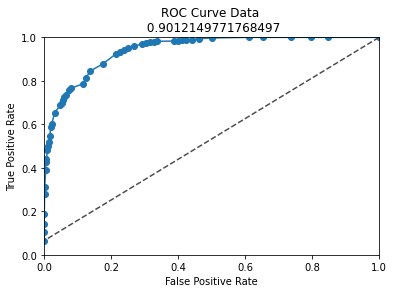

In [41]:
bb.plot.plot_validation_avgs(fprs_all, tprs_all, len(nodes), area_all, save=True, save_dir=VAL_DIR, show_plot=True)


accuracy
balanced_accuracy_score
explained_variance
f1
log-loss
max_error
precision
r2
recall
roc_auc_score


/Users/smgroves/Documents/anaconda3/envs/multiome/lib/python3.9/site-packages/booleabayes/plot.py:27: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q1 = df.groupby(df.variable).quantile(0.25)['value']
/Users/smgroves/Documents/anaconda3/envs/multiome/lib/python3.9/site-packages/booleabayes/plot.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q3 = df.groupby(df.variable).quantile(0.75)['value']


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

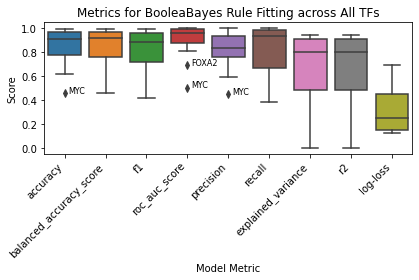

In [42]:
summary_stats = bb.tl.get_sklearn_metrics(VAL_DIR)
bb.plot.plot_sklearn_metrics(VAL_DIR)
bb.plot.plot_sklearn_summ_stats(summary_stats.drop("max_error", axis = 1), VAL_DIR, fname = "")

## Get attractors 
* `ut.find_avg_states()` returns a dictionary of the average states of each cluster and calls `get_avg_state_index()` to handle average state index files. This is solely used to set the phenotype/cluster label of any attractors found by looking at the nearest average state.
* View output format in `./test_data/output`:
    - average_states.txt
    - average_states_idx_Tumor1.txt
    - average_states_idx_Tumor2.txt
    - average_states.pdf

In [44]:
os.mkdir(ATTRACTOR_DIR)

**Find average states**

Average states:  {'repl': 16512, 'pdx1': 16512, 'nkx61': 16393, 'ph': 65407, 'fev_high_isl_neg': 50295, 'neurog3': 49789, 'sst_hhex': 65399, 'exo': 9897, 'scbeta': 16255, 'ph__pre': 65334, 'ec': 30590, 'foxj1': 63358}


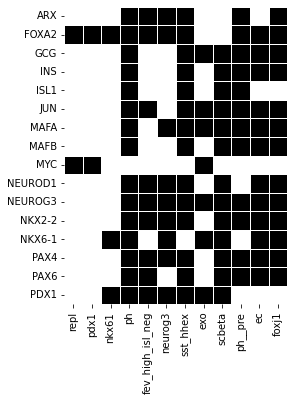

In [46]:
# Find average states from binarized data and write the avg state index files
average_states = bb.tl.find_avg_states(binarized_data, nodes, save_dir=OUTPUT_DIR)
print('Average states: ', average_states)

# Plot average state for each subtype
bb.plot.plot_attractors(f'average_states.txt', save_dir=ATTRACTOR_DIR)

**Find Attractors**
* The `tl.find_attractors()` function finds attractors within some vicinity of all of the starting data (assumption: attractors will fall somewhere close to data). The functions checks if `tf_basin < 0` and if so it calculates the minimum average distance between clusters to use as the "neighborhood size." 
* If `tf_basin is not < 0` , it uses the tf_basin value as the neighborhood size. We used 4 in the Wooten, Groves, et al. manuscript.
* `tl.write_attractor_dict()` writes an attractor dictionary to the specified output file location
* View output format in `./test_data/output`:
    - attractors_[cluster_name].txt
* `on_nodes` and `off_nodes` can be used to find attractors when the network is perturbed. For example, if `on_nodes = ["MYC"]`, MYC would be constitutively active in the network. This can be used to determine how perturbations change the stable states of the system. However, a more systematic way is defined below with perturbed random walks. 

In [48]:
tf_basin = 2
on_nodes = []
off_nodes = []

start = time.time()
# note this code also takes a while 
attractor_dict = bb.tl.find_attractors(binarized_data, rules, nodes, regulators_dict, tf_basin=tf_basin, 
                                    save_dir=ATTRACTOR_DIR, on_nodes=on_nodes, off_nodes=off_nodes)
end = time.time()
print('Time to find attractors: ', str(timedelta(seconds=end-start)))

repl
pdx1
nkx61
ph
... 95.24 % done
fev_high_isl_neg
neurog3
sst_hhex
exo
scbeta
ph__pre
ec
foxj1
Time to find attractors:  0:00:29.680558


**Save and Filter Attractors** 
* View output format in `./output/attractors`:
    - attractors_unfiltered.txt
    - attractors_filtered.txt


In [49]:
with open(f'{ATTRACTOR_DIR}/attractors_unfiltered.txt', 'w+') as outfile:
    bb.tl.write_attractor_dict(attractor_dict, nodes, outfile)

Use the average states of each cluster to filter attractors. 

In [ ]:
attractor_dict_filtered = bb.tl.filter_attractors(ATTRACTOR_DIR, nodes, clusters)

**Plotting attractors**

In [ ]:
# Plot attractors for each cluster
bb.plot.plot_attractors(f'{ATTRACTOR_DIR}/attractors_filtered.txt')

# Plot attractors sorted and clustered-- helpful if there are many attractors found. 
# bb.plot.plot_attractors_clustermap(fname = f"{ATTRACTOR_DIR}/attractors_filtered.txt")


**Jaccard heatmap**

Plot a heatmap of Jaccard distances between attractors. 

/Users/smgroves/Documents/anaconda3/envs/multiome/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<Figure size 720x720 with 0 Axes>

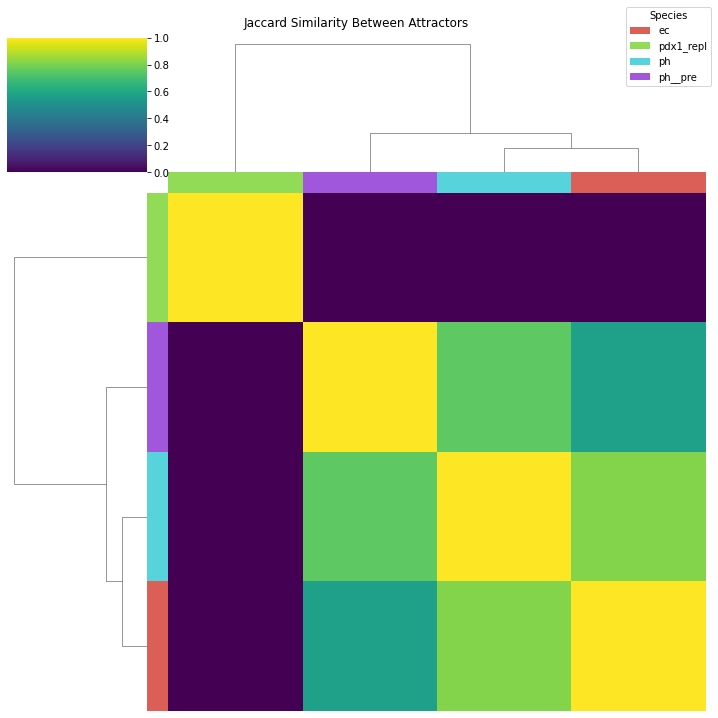

In [51]:
bb.plot.make_jaccard_heatmap(f'{ATTRACTOR_DIR}/attractors_filtered.txt', cmap='viridis',
                        clustered=True,
                        figsize=(10, 10), save=True)

## Perturbations

This section follows the perturbation tests done in Wooten, Groves, et al. 2019 (PLOS Comp Bio). See the paper for a full explanation of the perturbations. Briefly, each node of the network is kept on or off (overexpression vs knockout) and random walk simulations are run from each attractor. The amount of time it takes to leave an attractor gives a measure of how stable that attractor is, and how much that stability has changed with the perturbation. You can run single perturbations that you are interested in, or use the code below to run all perturbations and then rank-order them by effect.

View the documentation to see what all of the arguments do.

In [ ]:
os.mkdir(PERTURB_DIR)
bb.rw.random_walks(attractor_dict,
                    rules,
                    regulators_dict,
                    nodes,
                    save_dir = PERTURB_DIR,
                    radius=2,
                    perturbations=True,
                    iters=500,
                    max_steps=500,
                    stability=False,
                    reach_or_leave="leave",
                    random_start=False,
                    on_nodes=[],
                    off_nodes=[],
                    overwrite_walks=False
                    )

In [ ]:
bb.tl.perturbations_summary(attractor_dict,PERTURB_DIR, show = False, save = True, plot_by_attractor = True,
                                save_dir = "clustered_perturb_plots", save_full = True, significance = 'both', fname = "",
                                ncols = 5, mean_threshold = -0.3)